In [3]:
#.ns2 files
#bladder channel    = chan_ID - 133

#.ns5 files
#spine channel    = chan_ID - 135
#bladder channel  = chan_ID - 136

In [4]:
import brpylib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy.matrixlib
from scipy.fft import fft, fftfreq, fftshift
from scipy import signal
from scipy import stats
import statistics
import math
import random

import plotly.express as px
import plotly.graph_objects as go
import scipy.signal
import scipy

import pylab
from pathlib import Path

from statistics import median
from scipy.stats import linregress



Check BlackRock Library Version

In [5]:
if int(brpylib.brpylib_ver.split(".")[0]) < 2:
    raise Exception(f"Old library version unsupported: {brpylib.brpylib_ver}")

In [6]:
# day = "0"
# animal = "12_225"
# file = "002"
# file = "002"

# datafile = "O://PINT/_Projects/Bladder/012_19 SPARC/Data/"+animal+"/Day "+day+"/datafile"+file

# datafile_ns2 = datafile + ".ns2"
# datafile_ns5 = datafile + ".ns5"

# ## check if file Exists. Report if doesn't
# if datafile_ns2:
#     datapath_ns2 = Path(datafile_ns2)
# else:
#     raise NameError(f"Datafile {str(datapath_ns2)} does not exist.")

# if datafile_ns5:
#     datapath_ns5 = Path(datafile_ns5)
# else:
#     raise NameError(f"Datafile {str(datapath_ns5)} does not exist.")

data_drive = 'O:'
base_dir = fr'{data_drive}\PINT\_Projects\Bladder\012_19 SPARC\Data\Curated data\AutoCurate'
fn = '12_225.acute.saline.0.7.parquet' #
load_file = Path(base_dir, fn)
df = pd.read_parquet(load_file)

Filter Functions

In [7]:
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = signal.lfilter(b, a, data)
    return y

#Spine = Spine.squeeze()
#Bladder = Bladder.squeeze()

#N1 = butter_bandpass_filter(Spine, 110, 5000, 30000, 3)
#N2 = butter_bandpass_filter(Bladder, 110, 5000, 30000, 3)

def xcor(x,y):
    cor = signal.correlate(x,y)
    lags = signal.correlation_lags(len(x), len(y))

    sample_rate = 30000

    lags = lags/sample_rate

    startIndex = int(np.ravel(np.where(lags == -0.05)))
    endIndex = int(np.ravel(np.where(lags == 0.05)))

    cor = cor[startIndex:endIndex]

    med = statistics.median(cor)

    cor = cor - med

    lags = lags[startIndex:endIndex]

    return cor, lags


def crosspeak(x,y):

    adeltlags = y[1100:1500]
    adeltregion = x[1100:1500]

    peaks, _ = signal.find_peaks(adeltregion, prominence=0.2)
    return 0
    if bool(peaks):
        return peaks+1100
    else:
        return 1480

def peakfind(y):

    # Settings: lag = 30, threshold = 5, influence = 0
    lag = 50
    threshold = 3
    influence = 1

    # Run algo with settings from above
    result = thresholding_algo(y, lag=lag, threshold=threshold, influence=influence)

    # Plot result
    pylab.subplot(211)
    #pylab.ylim(-.05, .05)
    pylab.plot(np.arange(1, len(y)+1), y)

    pylab.plot(np.arange(1, len(y)+1),
            result["avgFilter"], color="cyan", lw=2)

    pylab.plot(np.arange(1, len(y)+1),
            result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)

    pylab.plot(np.arange(1, len(y)+1),
            result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)

    pylab.subplot(212)
    pylab.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)
    pylab.ylim(-1.5, 1.5)
    pylab.show()
    
def movingxcor(x,y):
    
    box = 15000 #30000 = 1 sec
    sample_rate = 30000
    corsize = 3000

    samples = int(np.ceil(len(x)/box))
    maxtime = len(x)/sample_rate

    result = np.zeros([samples, corsize])
    holdcor = np.zeros(3000)

    neural = np.zeros(samples)

    j = 0

    for i in range(int(box/2),int(len(x))-box,box):
        start = int(i-(box/2))
        end = int(i+(box/2))
        cor, lags = xcor(x[start:end],y[start:end])
        
        peak = crosspeak(cor,lags)
        #peaks = peakfind(cor)

        holdresult = np.reshape(cor, corsize)
        result[j] = holdresult
        neural[j] = cor[peak]
        holdcor = cor/2
        j += 1
    
    med = statistics.median(neural)

    neural = neural - med

    time = np.linspace(0,maxtime,samples)
    plt.pcolormesh(time, lags, np.rot90(result), cmap='RdBu', vmin=-0.001, vmax=0.001)
    plt.axhline(lags[1500],0,maxtime,c="black")
    plt.ylabel("Lag (s)")
    plt.xlabel("Time (s)")
    plt.ylim(-0.01,0.01)

    return neural, result, lags, time

#i.e
#neuralAct, Result, lags, time = movingxcor(N1,N2)


In [8]:
from scipy.interpolate import interp1d

def downsample(array, npts):
    interpolated = interp1d(np.arange(len(array)), array, axis = 0, fill_value = 'extrapolate')
    downsampled = interpolated(np.linspace(0, len(array), npts))
    return downsampled

In [9]:
def showdata(t_pressure,t_neural,Pressure,N1,N2):
    plt.rcParams["figure.figsize"]=10,5

    fig, axs = plt.subplots(3, 1)

    axs[0].plot(t_pressure,Pressure, color='red')
    axs[0].set(ylabel='Pressure (mmHg)', xlabel='Time (s)')
    axs[0].set_title('Bladder pressure')
    
    axs[1].plot(t_neural,N2)
    axs[1].set(ylabel='Neural activity (V)', xlabel='Time (s)')
    axs[1].set_title('Neural activity bladder')


    axs[2].plot(t_neural,N1)
    axs[2].set(ylabel='Neural activity (V)', xlabel='Time (s)')
    axs[2].set_title('Neural activity spine')


Params to Load

In [10]:
# elec_ids     = 'all'    # 'all' is default for all (1-indexed)
# start_time_s = 0      # 0 Beggining of File
# data_time_s  = 'all'      # 'all' is default for all
# #down_sample   = 1       # 1 is default

Load NSX Files

In [11]:
# # Open file and extract headers
# ns2_file = brpylib.NsxFile(str(datapath_ns2))
# # Extract data - note: data will be returned based on *SORTED* elec_ids, see cont_data['elec_ids']
# cont_data_ns2 = ns2_file.getdata(elec_ids, start_time_s, data_time_s, full_timestamps=False)
# # Close the nsx file now that all data is out
# ns2_file.close()

# # Open file and extract headers
# ns5_file = brpylib.NsxFile(str(datapath_ns5))
# # Extract data - note: data will be returned based on *SORTED* elec_ids, see cont_data['elec_ids']
# cont_data_ns5 = ns5_file.getdata(elec_ids, start_time_s, data_time_s, full_timestamps=True)
# # Close the nsx file now that all data is out
# ns5_file.close()

Scale Loaded NSX Files

In [12]:
# seg_id = 0

# #Pressure Calibration (can find the calibration for each experiment in IGOR Procedure of experiment)
# k_PressureOffset = 0.0132
# k_PressureCalibration = .0042

# ch_pressure = cont_data_ns2["elec_ids"].index(133)
# ch_spine    = cont_data_ns5["elec_ids"].index(135)
# ch_bladder  = cont_data_ns5["elec_ids"].index(136)
# #t_neural = (cont_data_ns5["data_headers"][seg_id]["Timestamp"] / cont_data_ns5["samp_per_s"])
# #t_pressure = (cont_data_ns2["data_headers"][seg_id]["Timestamp"] / cont_data_ns2["samp_per_s"])


# rawPressureData = cont_data_ns2["data"][seg_id][ch_pressure]
# rawSpineData = cont_data_ns5["data"][seg_id][ch_spine]
# rawBladderData = cont_data_ns5["data"][seg_id][ch_bladder]

# #scalefactor = 1 / (ExtendedHeader.iMaxDigital / ExtendedHeader.iMaxAnalog) / 1000
# scaleFactor = 0.000152592547379986

# Pressure = ((rawPressureData*scaleFactor - k_PressureOffset)/k_PressureCalibration)
# Spine = (rawSpineData*scaleFactor)
# Bladder = (rawBladderData*scaleFactor)

Pressure = df['Pressure'].to_numpy()
Spine = df['nSpine'].to_numpy()
Bladder = df['nBladder'].to_numpy()
timestamp = df.index.values

#Filter Raw Data
N1 = butter_bandpass_filter(Spine, 110, 5000, 30000, 3)
N2 = butter_bandpass_filter(Bladder, 110, 5000, 30000, 3)

# t_pressure = np.linspace(0,np.size(rawPressureData)/cont_data_ns2['samp_per_s'],np.size(rawPressureData))
# t_neural = np.linspace(0,np.size(rawSpineData)/cont_data_ns5['samp_per_s'],np.size(rawSpineData))

t_pressure = df.index.values
t_neural = df.index.values

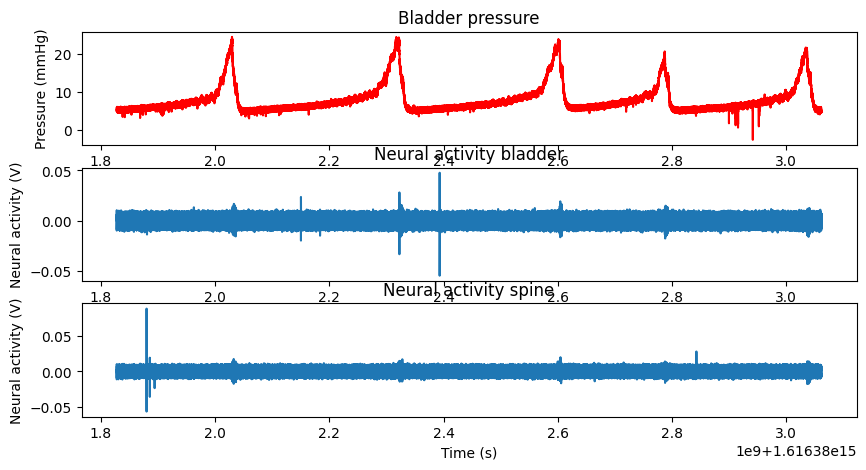

In [13]:
showdata(t_pressure,t_neural,Pressure,N1,N2)

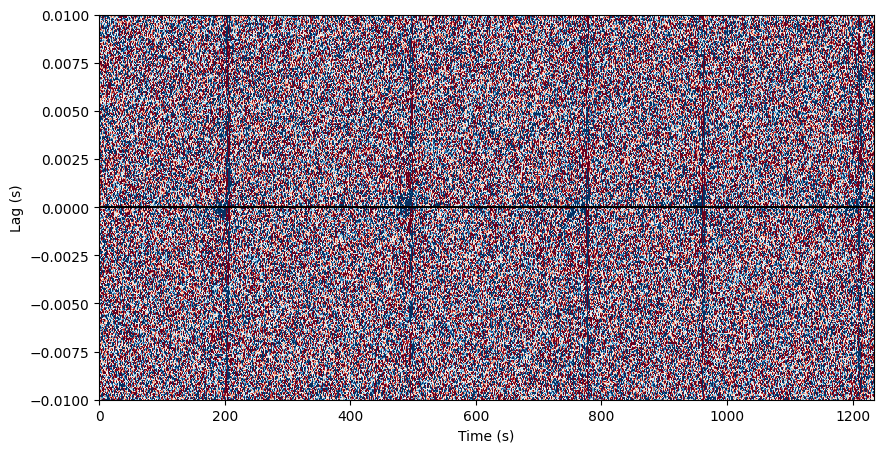

In [14]:
neuralAct, Result, lags, time = movingxcor(N1,N2)

0
-0.6666666666666643  ms


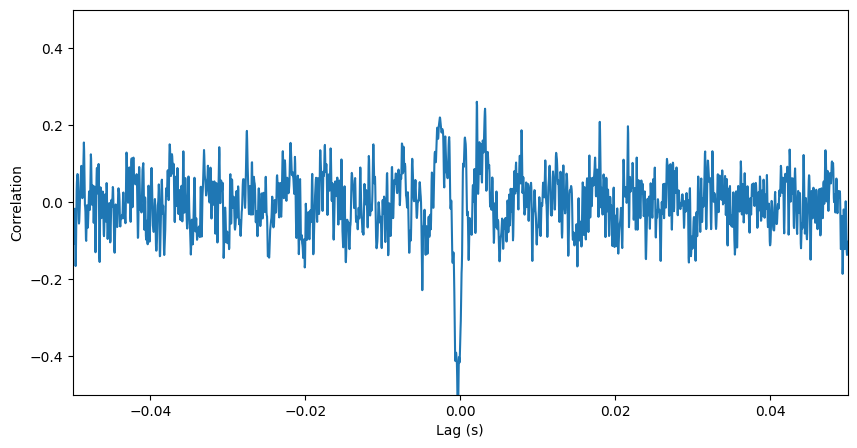

In [15]:
cor, lags = xcor(N1,N2)

peak = crosspeak(cor,lags)
print(peak)

plt.plot(lags,-(cor))
#plt.plot(TimeCorrelation,Correlation)
#plt.vlines(lags[1299],-5,8,'k')
#plt.vlines(lags[1498],-5,8,'k')
plt.xlabel("Lag (s)")
plt.ylabel("Correlation")
plt.xlim(-0.05,0.05)
plt.ylim(-.5,.5)

print(-(50-(0.1/3000 * 1480)*1000)," ms")

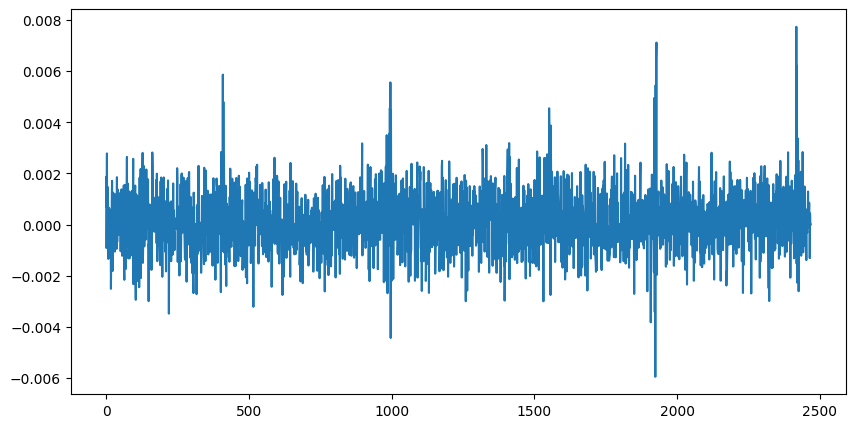

In [16]:
neuralAct = Result[:,1480]
plt.plot(neuralAct)

NORMAL INTEGRATION

hold_J 1497
Bin: 2468
Pearson: 0.09747903946596255
pval: 100000
lag: -0.10000000000000142  ms


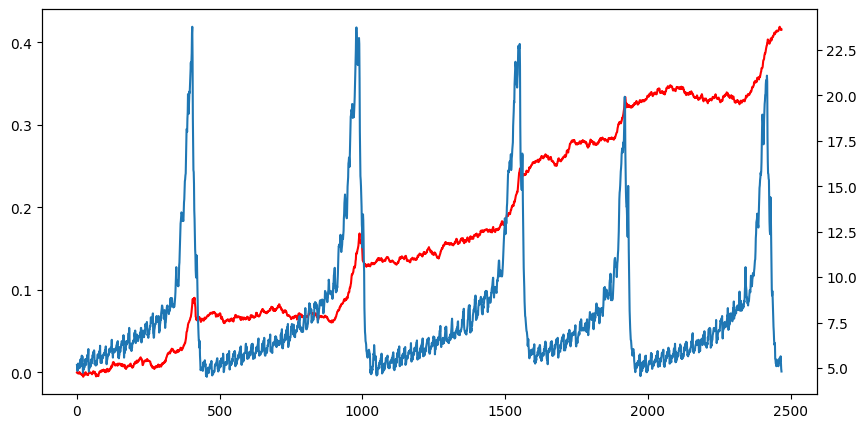

In [17]:
hold_rho = 0
hold_i = 0
hold_j = 1440
hold_pval = 100000

sumOf = pd.DataFrame()
sumOf=(Result[:,1497:1498].sum(axis=1))   #1440:1480   /    1300:1350
n1 = pd.Series(sumOf)
downsampled_pressure = downsample(Pressure, len(sumOf))

for j in range(1497,1498):
    sumOf=(Result[:,j:(j+1)].sum(axis=1))
    n = pd.Series(400)

    for i in range(0,len(sumOf)):
        n[i] = sum(sumOf[:i])

    rho, pval = stats.pearsonr(n, downsampled_pressure) #stats.spearmanr(n, downsampled_pressure) stats.pearsonr()
    if abs(rho) > hold_rho:
        hold_j = j
        hold_rho = abs(rho)
        hold_i = i
        hold_downsampled_var = n

print("hold_J",hold_j)
print("Bin:",hold_i)
print("Pearson:",hold_rho)
print("pval:",hold_pval)
print("lag:",-(50-(0.1/3000 * hold_j)*1000)," ms")

##plot bestax.set_ylabel("Neural activity (au)")
if hold_downsampled_var[0] > hold_downsampled_var[len(hold_downsampled_var)-1]:
    hold_downsampled_var=hold_downsampled_var*-1
fig,ax = plt.subplots()
ax.plot(hold_downsampled_var,"r")
ax2=ax.twinx()
ax2.plot(downsampled_pressure)


hold_J 1494
Bin: 19    - 9.5 s
Pearson: 0.7430422354545876
pval: 0.0
lag: -0.19999999999999574  ms


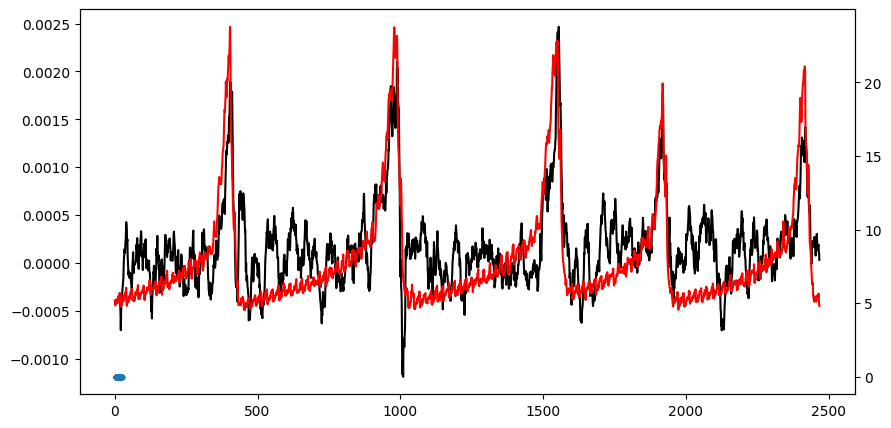

In [18]:
hold_rho = 0
hold_i = 0
hold_j = 0
hold_pval = 100000
sumOf = pd.DataFrame()
sumOf=(Result[:,1497:1498].sum(axis=1))   #1440:1480   /    1300:1350
n1 = pd.Series(sumOf)
downsampled_pressure = downsample(Pressure, len(sumOf))

for j in range(1200,1499):
    sumOf=(Result[:,j:(j+1)].sum(axis=1))
    n1 = pd.Series(sumOf)
    #print(sum(sumOf))
    for i in range(1,20):
        
        var = n1.rolling(i).mean()
        rho, pval = stats.pearsonr(var[i:], downsampled_pressure[i:])
        if abs(rho) > hold_rho:
            #if pval < hold_pval:
            hold_j = j
            hold_pval = abs(pval)
            hold_rho = abs(rho)
            hold_i = i
            hold_downsampled_var = var

print("hold_J",hold_j)
print("Bin:",hold_i,"   -",hold_i/2,"s")
print("Pearson:",hold_rho)
print("pval:",hold_pval)
print("lag:",-(50-(0.1/3000 * hold_j)*1000)," ms")

if hold_downsampled_var[i] > hold_downsampled_var[len(hold_downsampled_var)-1]:
    hold_downsampled_var=hold_downsampled_var*-1
##plot bestax.set_ylabel("Neural activity (au)")
fig,ax = plt.subplots()
ax.plot(hold_downsampled_var,"black")
ax2=ax.twinx()
ax2.plot(downsampled_pressure,"r")
# show
plt.plot(downsampled_pressure,hold_downsampled_var,".")

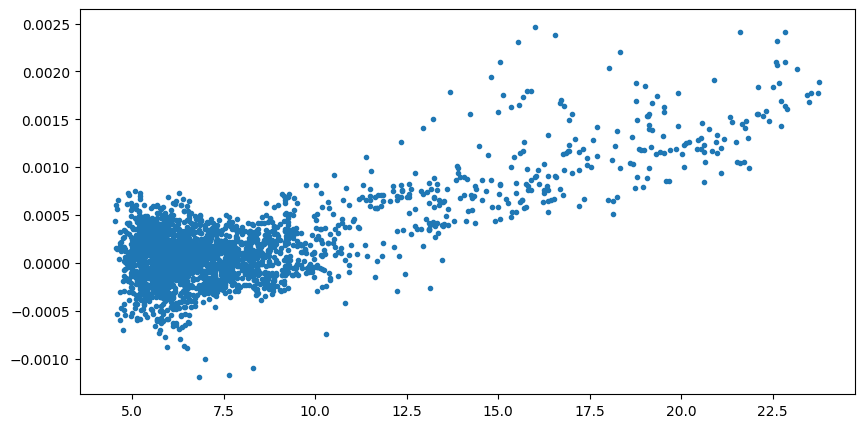

In [19]:
plt.plot(downsampled_pressure,hold_downsampled_var,".")

RANDOM SUM

c:\Users\sungw\anaconda3\envs\cloud_pint\lib\site-packages\scipy\stats\_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


1492 1498
hold_J 0
Bin: 25
Pearson: 0.7922111860168707
pval: 0.0
lag: -0.2666666666666657  ms -  -0.06666666666666288  ms


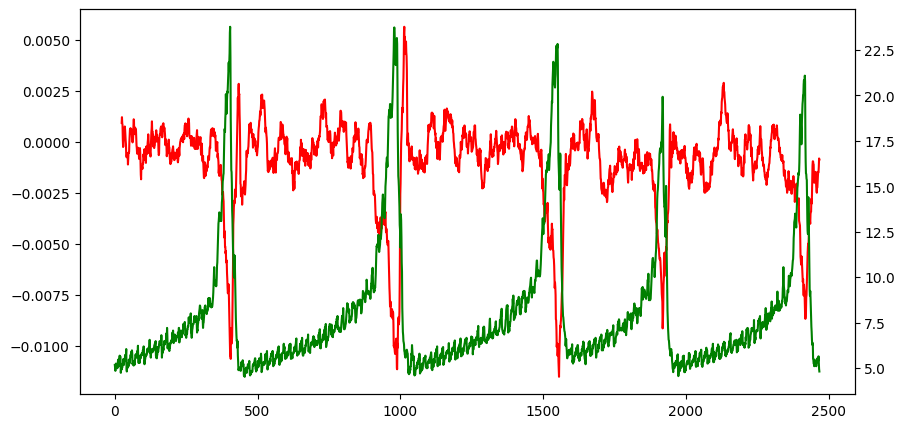

In [20]:
hold_rho = 0
hold_i = 0
hold_j = 0
hold_low = 0
hold_high = 0
hold_pval = 100000
sumOf = pd.DataFrame()
sumOf=(Result[:,1497:1498].sum(axis=1))   #1440:1480   /    1300:1350
n1 = pd.Series(sumOf)
downsampled_pressure = downsample(Pressure, len(sumOf))

randlow = 0
randhigh = 0

maxsearch = 1499
minsearch = 1490

maxrange = maxsearch-minsearch


for k in range(0,20):
    #print(k,hold_rho,hold_low,hold_high)
    
    randlow = random.randrange(minsearch,maxsearch)
    randhigh = randlow + random.randrange(0,maxsearch-randlow)


    sumOf=(Result[:,randlow:randhigh].sum(axis=1))


    n1 = pd.Series(sumOf)
    #print(sum(sumOf))
    for i in range(1,30):
            
        var = n1.rolling(i).mean()
        rho, pval = stats.pearsonr(var[i:], downsampled_pressure[i:]*100)
        if abs(rho) > hold_rho:
            #if pval < hold_pval:
            hold_low = randlow
            hold_high = randhigh
            hold_pval = abs(pval)
            hold_rho = abs(rho)
            hold_i = i
            hold_downsampled_var = var

print(hold_low,hold_high)
print("hold_J",hold_j)
print("Bin:",hold_i)
print("Pearson:",hold_rho)
print("pval:",hold_pval)
print("lag:",-(50-(0.1/3000 * hold_low)*1000)," ms - ",-(50-(0.1/3000 * hold_high)*1000)," ms")

if hold_downsampled_var[i] > hold_downsampled_var[len(hold_downsampled_var)-1]:
    hold_downsampled_var=hold_downsampled_var*-1
##plot bestax.set_ylabel("Neural activity (au)")
fig,ax = plt.subplots()
ax.plot(-hold_downsampled_var,"r")
ax2=ax.twinx()
ax2.plot(downsampled_pressure,"g")

POWERBAND

In [21]:
def powerband(high,low,wind):
    high = int((wind/30000)*high)
    low = int((wind/30000)*low)

    fB, tB, SxxB = signal.spectrogram(N2, 30000,window=signal.get_window('hann',wind))

    bandB = [None]*np.size(tB)

    for i in range(0,np.size(tB)):
        sum_values = (1/(fB[high]-fB[low]))*math.log(sum(SxxB[low:high,i]))
        bandB[i] = sum_values

    bandB = bandB + abs(min(bandB))
    bandB = bandB/max(bandB)

    plt.pcolormesh(tB, fB, SxxB,vmin=0, vmax=0.00000005)
    plt.axhline(y=fB[low], color = 'r')
    plt.axhline(y=fB[high], color = 'r')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim([0, 1000])
    plt.title('Bladder')
    plt.text(1,round(fB[low])+10, '$f_{1}$: '+str(round(fB[low])), fontsize=22, color='w')
    plt.text(1,round(fB[high])+10, '$f_{2}$: '+str(round(fB[high])), fontsize=22, color='w')
    plt.show()
    
    fS, tS, SxxS = signal.spectrogram(N1, 30000,window=signal.get_window('hann',wind))

    plt.pcolormesh(tS, fS, SxxS,vmin=0, vmax=0.00000005)
    plt.axhline(y=fB[low], color = 'r')
    plt.axhline(y=fB[high], color = 'r')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.ylim([0, 1000])
    plt.title('Spine')
    plt.text(1,round(fB[low])+10, '$f_{1}$: '+str(round(fB[low])), fontsize=22, color='w')
    plt.text(1,round(fB[high])+10, '$f_{2}$: '+str(round(fB[high])), fontsize=22, color='w')

    plt.plot(tB,bandB, 'b')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.title("Bladder")
    plt.show()
    bandS = [None]*np.size(tS)

    for i in range(0,np.size(tS)):
        sum_values = (1/(fS[high]-fS[low]))*math.log(sum(SxxS[low:high,i]))
        bandS[i] = sum_values

    bandS = bandS + abs(min(bandS))
    bandS = bandS/max(bandS)


    plt.plot(tS,bandS,'r')
    plt.xlabel('Time (s)')
    plt.ylabel('Power')
    plt.title('Spine')
   

    def smooth(y, box_pts):
        box = np.ones(box_pts)/box_pts
        y_smooth = np.convolve(y, box, mode='same')
        return y_smooth

    bandAVG = (bandS+bandB)/2
    bandAVGsmooth = pd.Series(bandAVG)
    bandAVGsmooth = bandAVGsmooth.rolling(10).mean()
    #bandAVGvar = bandAVGsmooth.rolling(10).var()
    
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax2.plot(tS,bandS,'r')
    ax2.plot(tB,bandB, 'b')
    ax2.plot(tB,bandAVG, 'g')
    #ax2.plot(time_neural,(m)*100)
    #ax2.plot(time_neural,(s)*100)
    
   
    #unhacsh this one
    #ax2.plot(tB,(bandAVGsmooth))
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Power')
    ax1.plot(t_pressure,Pressure, 'k')
    ax1.set_ylabel('Pressure (mmHg)')
    plt.show()

    return bandAVGsmooth, bandS, bandB

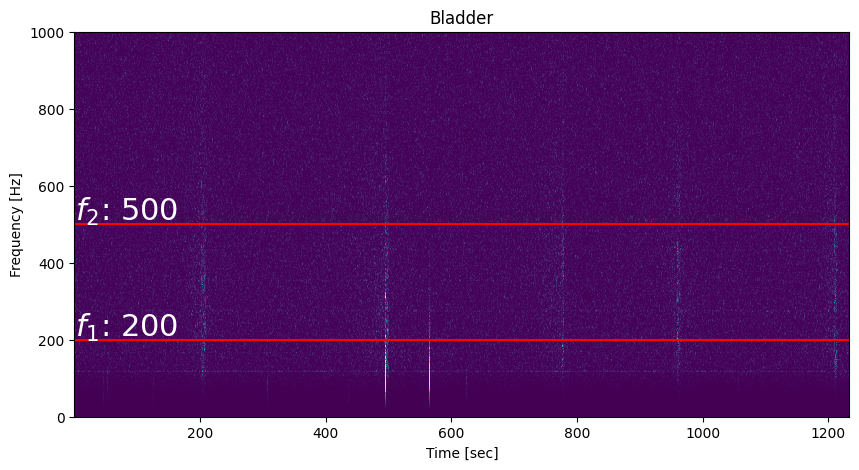

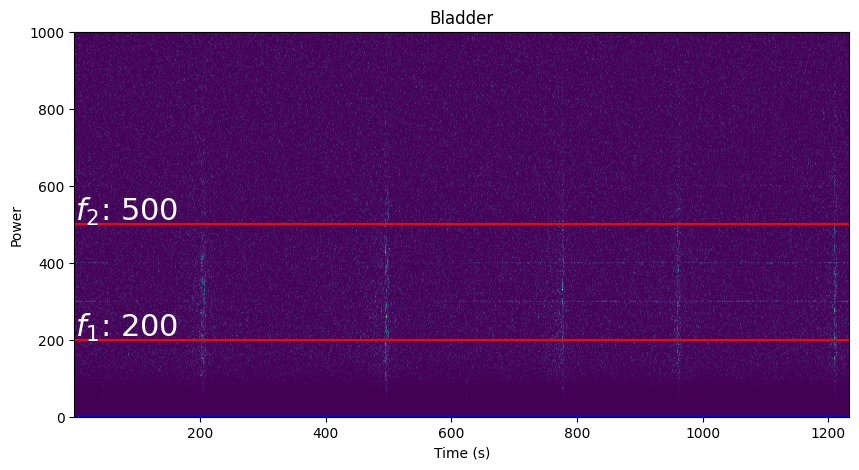

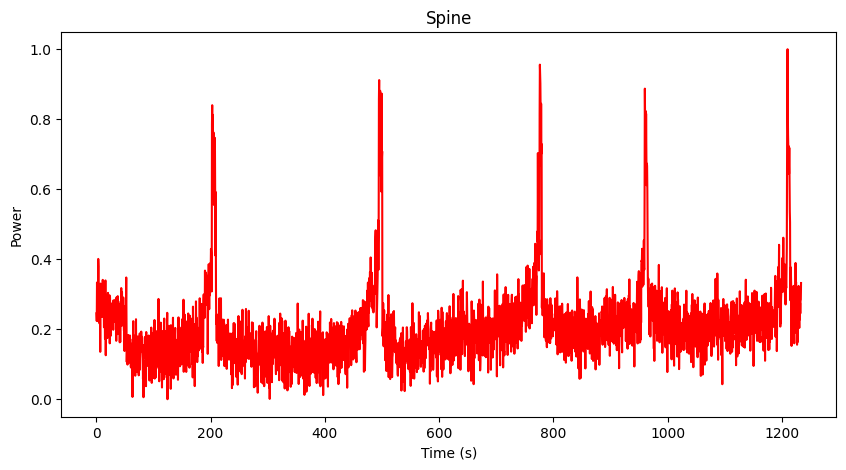

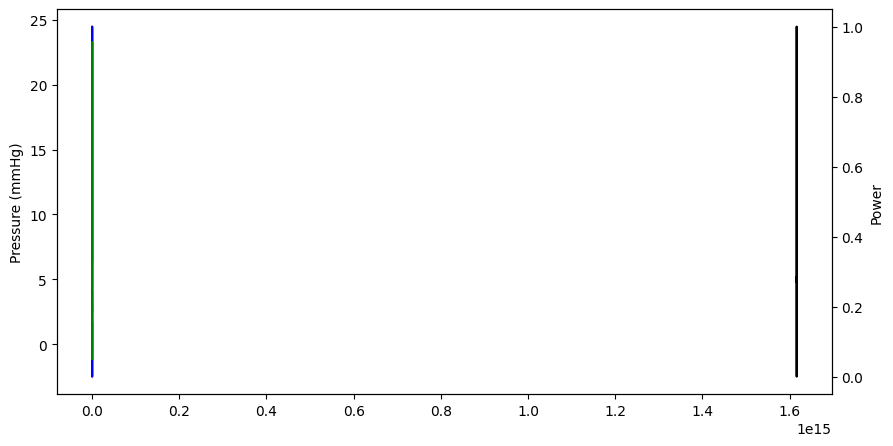

(0            NaN
 1            NaN
 2            NaN
 3            NaN
 4            NaN
           ...   
 2815    0.223603
 2816    0.230370
 2817    0.228535
 2818    0.230193
 2819    0.228468
 Length: 2820, dtype: float64,
 array([0.24552902, 0.22342714, 0.33349831, ..., 0.28339417, 0.2840313 ,
        0.33203638]),
 array([0.15513948, 0.14027266, 0.14701959, ..., 0.16124064, 0.18898929,
        0.18603498]))

In [22]:
high = 500
low = 200
wind = 15000

powerband(high,low,wind)

0 206 0 1492 1498
1 136 0.6792916117900611 206 300
2 389 0.6792916117900611 206 300
3 177 0.6792916117900611 206 300
4 176 0.6807300201384773 177 294
5 240 0.6807300201384773 177 294
6 140 0.6807300201384773 177 294
7 115 0.6807300201384773 177 294
8 303 0.6807300201384773 177 294
9 146 0.6807300201384773 177 294
10 255 0.6807300201384773 177 294
11 365 0.6807300201384773 177 294
12 308 0.6807300201384773 177 294
13 237 0.6807300201384773 177 294
14 356 0.6807300201384773 177 294
15 350 0.6807300201384773 177 294
16 145 0.6807300201384773 177 294
17 113 0.6807300201384773 177 294
18 252 0.6807300201384773 177 294
19 213 0.6807300201384773 177 294
20 387 0.6807300201384773 177 294
21 385 0.6807300201384773 177 294
22 230 0.6807300201384773 177 294
23 363 0.6807300201384773 177 294
24 366 0.6807300201384773 177 294
25 263 0.6807300201384773 177 294
26 289 0.6807300201384773 177 294
27 134 0.6807300201384773 177 294
28 175 0.6807300201384773 177 294
29 300 0.6807300201384773 177 294
30 11

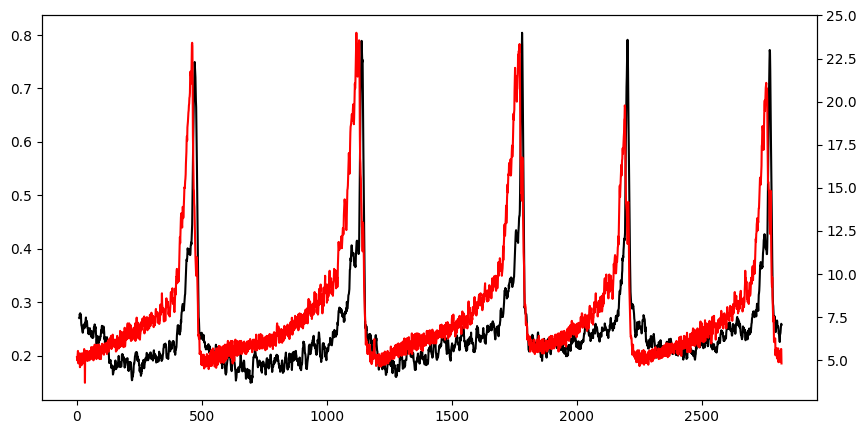

In [23]:
hold_rho = 0
hold_i = 0
hold_j = 0
hold_pval = 100000

high = 500
low = 200
wind = 15000

high = int((wind/30000)*high)
low = int((wind/30000)*low)

fB, tB, SxxB = signal.spectrogram(N2, 30000,window=signal.get_window('hann',wind))
bandB = [None]*np.size(tB)

for i in range(0,np.size(tB)):
    sum_values = (1/(fB[high]-fB[low]))*math.log(sum(SxxB[low:high,i]))
    bandB[i] = sum_values

bandB = bandB + abs(min(bandB))
bandB = bandB/max(bandB)


fS, tS, SxxS = signal.spectrogram(N1, 30000,window=signal.get_window('hann',wind))
bandS = [None]*np.size(tS)

for i in range(0,np.size(tS)):
    sum_values = (1/(fS[high]-fS[low]))*math.log(sum(SxxS[low:high,i]))
    bandS[i] = sum_values

bandS = bandS + abs(min(bandS))
bandS = bandS/max(bandS)

bandAVG = (bandS+bandB)/2
bandAVGsmooth = pd.Series(bandAVG)
bandAVGsmooth = bandAVGsmooth.rolling(10).mean()

n1 = pd.Series(bandAVGsmooth)
downsampled_pressure = downsample(Pressure, len(n1))


randlow = 0
randhigh = 0

maxsearch = 500
minsearch = 110

maxrange = maxsearch-minsearch


for k in range(0,500):
    randlow = random.randrange(minsearch,maxrange)
    print(k,randlow, hold_rho, hold_low, hold_high)
    randhigh = randlow + random.randrange(1,(maxsearch-randlow))
    
    bandB = [None]*np.size(tB)
    for i in range(0,np.size(tB)):
        sum_values = (1/(fB[randhigh]-fB[randlow]))*math.log(sum(SxxB[randlow:randhigh,i]))
        bandB[i] = sum_values
    bandB = bandB + abs(min(bandB))
    bandB = bandB/max(bandB)

    bandS = [None]*np.size(tS)
    for i in range(0,np.size(tS)):
        sum_values = (1/(fS[high]-fS[low]))*math.log(sum(SxxS[low:high,i]))
        bandS[i] = sum_values
    bandS = bandS + abs(min(bandS))
    bandS = bandS/max(bandS)

    bandAVG = (bandS+bandB)/2
    bandAVGsmooth = pd.Series(bandAVG)
    var = bandAVGsmooth.rolling(10).mean()

    rho, pval = stats.pearsonr(var[20:], downsampled_pressure[20:])
    if abs(rho) > hold_rho:
        #if pval < hold_pval:
        hold_low = randlow
        hold_high = randhigh
        hold_pval = abs(pval)
        hold_rho = abs(rho)
        #hold_i = i
        hold_downsampled_var = var

print(hold_low,hold_high)
#print("hold_i",hold_i)
print("hold_rho",hold_rho)
print("hold_pval",hold_pval)

if hold_downsampled_var[i] > hold_downsampled_var[len(hold_downsampled_var)-1]:
    hold_downsampled_var=hold_downsampled_var*-1
##plot bestax.set_ylabel("Neural activity (au)")
fig,ax = plt.subplots()
ax.plot(hold_downsampled_var,"k")
ax2=ax.twinx()
ax2.plot(downsampled_pressure,"r")